# Analyzing NSW Public Transports Usage - Opal Cards' Tap-ons and Tap-offs

## Problem Tasks: 

`Opal card` is the transport card which is used to tap on when entering the station, and to tap off when exit from the station in destination. The analysis of the card usage will include: 
- Examine the Opal usage data from Transport NSW and identify the patterns of different transport modes including bus, rail and ferry. 
- Having collected data about average income and age range of NSW people, we apply a suitable analysis technique in order to decide if there is a relationship between transport usage and a specific factor.

## Import Libraries

In [1]:
import pandas as pd
import numpy as np
from numpy import mean
from numpy import std

# Plot
import seaborn as sns
import matplotlib.pylab as plt
%matplotlib inline
from sklearn.metrics import plot_confusion_matrix

# Functions used for linear regression
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn import metrics

# Functions used for logistic regression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, plot_confusion_matrix
from sklearn.feature_selection import RFE
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold

# Functions used for K-Nearest Neighbours Classifier
from sklearn.neighbors import KNeighborsClassifier

# Functions used for Naive Bayes
from sklearn.naive_bayes import GaussianNB

# Functions used for Neural Network
from sklearn.neural_network import MLPClassifier

# Functions used for Clustering
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances
from scipy.cluster.hierarchy import linkage, dendrogram, cut_tree
from scipy.spatial.distance import pdist 

# Ignore Warning
import warnings
warnings.filterwarnings("ignore")

## Data Description 

The dataset obtained from [Transport NSW page](https://www.transport.nsw.gov.au/data-and-research/travel-insights?fbclid=IwAR1Bx6GzgoeFsDrZw9JYehj_ARCbovy1VZHGvJ61T00RExMrGxqUh7_LUi4)  is about the tap-on and tap-off rates of Opal cards which record the number of passengers who take the public transports daily (_these satistical data includes passengers of all modes of transports_). 
 
4 suburbs in Greater Sydney, NSW, Australia filter for the dataset include Macquarie Parks, Strathfield, Parramatta and Chatswood via the `Mac Park vs the rest of Syd.xlsx` data file. The dataset contains records of tap-on events and tap-off events of the four suburbs from 30 August 2021 to 19 September 2021.

**Steps:**
- **Data manipulation**: grouping data based on the distance of two nearby suburbs.
- **Data exploration**: plotting graphs to check the correlation of tap-ons and tap-offs between 2 suburbs. 
- **Model building**: building a Linear Regression model to _predict the number of tap-on events_ at one suburb _based on the tap-off events_ at the nearby suburb.

**Goals:**

Helping passenger plan ahead based on the traveling trends under the Covid-19 circumstance, especially in the key commercial centres such as Parramatta and Chatswood where high volume of transport uses are witnessed.

## Data Manipulation

Now we import the data file and load it into a dataframe. 

In [2]:
# Import data and convert into the dataframe
df_taps = pd.read_excel("data/Mac Park vs the rest of Syd.xlsx", index_col = 0, engine="openpyxl")
df_taps.head(5)

,Suburbs,Tap-ons,Tap-offs
Dates,,,
30/8/2021,Macquarie Park,3700,3300
30/8/2021,Parramatta,9700,9200
30/8/2021,Strathfield,1900,1400
30/8/2021,Chatswood,5000,4900
31/8/2021,Macquarie Park,3700,3100


## Data Summary

In [ ]:
# Examine the dataset dimension
print("# of rows:",df_taps.shape[0])
print("# of columns:",df_taps.shape[1])

# rows in the dataset: 84
# columns in the dataset: 3


In [4]:
# summarise the tap-on and tap-off rates over the recorded days
df_taps.describe()

,Tap-ons,Tap-offs
count,84.000000,84.000000
mean,4647.619048,4303.571429
std,2947.348254,2909.247674
min,900.000000,300.000000
25%,2000.000000,1700.000000
50%,3950.000000,3600.000000
75%,5700.000000,5500.000000
max,11000.000000,10500.000000


In [5]:
# Check the number of records in each Suburb
df_taps['Suburbs'].value_counts()

Strathfield       21
Chatswood         21
Macquarie Park    21
Parramatta        21
Name: Suburbs, dtype: int64

* **_comment:_** There are 21 records (21 days) on the tap-on events and tap-off events in each suburb.

We separate the records for each distinct suburb.

In [6]:
# Group the dataframe based on Suburbs
mac_taps = df_taps[df_taps.Suburbs == "Macquarie Park"]
chats_taps = df_taps[df_taps.Suburbs == "Chatswood"]
strath_taps = df_taps[df_taps.Suburbs == "Strathfield"]
parra_taps = df_taps[df_taps.Suburbs == "Parramatta"]

In [7]:
# Summarise the tap-on and tap-off rate for each suburb
print("Summary of Macquarie Park:\n", mac_taps.describe())
print("\nSummary of Chatswood:\n", chats_taps.describe())
print("\nSummary of Strathfield:\n", strath_taps.describe())
print("\nSummary of Parramatta:\n", parra_taps.describe())

Summary of Macquarie Park:
            Tap-ons     Tap-offs
count    21.000000    21.000000
mean   3342.857143  3085.714286
std     889.140837   895.704033
min    1500.000000   900.000000
25%    2600.000000  2500.000000
50%    3800.000000  3500.000000
75%    3900.000000  3600.000000
max    4200.000000  4100.000000

Summary of Chatswood:
            Tap-ons     Tap-offs
count    21.000000    21.000000
mean   4800.000000  4609.523810
std    1196.244122  1135.739742
min    1900.000000  1900.000000
25%    4100.000000  4000.000000
50%    5300.000000  5100.000000
75%    5700.000000  5400.000000
max    5900.000000  5600.000000

Summary of Strathfield:
            Tap-ons     Tap-offs
count    21.000000    21.000000
mean   1723.809524  1266.666667
std     418.216166   468.330368
min     900.000000   300.000000
25%    1300.000000   900.000000
50%    2000.000000  1500.000000
75%    2000.000000  1600.000000
max    2100.000000  1700.000000

Summary of Parramatta:
             Tap-ons      Tap-offs

* **_Interpretation:_**

From the summary, we can conclude that Parramatta was the busiest stop (all transport modes) in the period from 30 August to 19 September in 2021, which the average tap-ons and tap-offs of Opal Card (number of passengers) were up to roughly 8724 and 8252 respectively. The least busy transport stop was in Strathfield, where the average tap-on rate was nearly 1724 and the average tap-off rate was 1267.

### Group Data based on nearby Suburbs

* **_Comment:_**

We group two suburbs which are nearby in order to prepare for building the model of regression. In this case, we group Macquarie Park and Chatswood since the stations of these two suburbs are nearby, and also they include Metro service. On the other hand, we group Parramatta and Strathfield based on the distance (both located on the West side of Sydney). 

*_NOTE:_* we will not include the column "Suburbs" in our grouped datasets, since we only include either tap-ons or tap-offs of a suburb when grouping. For example, if we only include the tap-ons in Macquarie Park, then we group with the Tap-offs of Chatswood (include "Suburbs" column). This then leads to the confusion that whether the "Tap-ons" column is referred to Chatswood or Macquarie Park. Therefore, **we only include the "Tap-ons" of one suburb and the "Tap-offs" of another suburb, then change the column names according to their suburbs (e.g. "Tap-ons" to "Tap-ons (Mac Park)")**.

**First Group:** we group Macquarie Park and Chatswood

* _Tap-ons of Macquarie Park and Tap-offs of Chatswood_

In [8]:
# create a temporary dataframe that drops the unrelated columns
temp = mac_taps.drop(['Suburbs', 'Tap-offs'],1)

# Add a tap-offs of Chatswood and rename the columns to clearly state which column belongs to which suburb
mac_chats_taps = temp.rename(columns = {'Tap-ons':'Tap-ons (Mac Park)'})
mac_chats_taps['Tap-offs (Chatswood)'] = chats_taps['Tap-offs']
mac_chats_taps.head(3)

,Tap-ons (Mac Park),Tap-offs (Chatswood)
Dates,,
30/8/2021,3700,4900
31/8/2021,3700,4800
1/9/2021,3700,5400


* _Tap-ons of Chatswood and Tap-offs of Macquarie Park_

In [9]:
# create a temporary dataframe that drops the unrelated columns
temp = chats_taps.drop(['Suburbs', 'Tap-offs'],1)

# Add a tap-offs of Macquarie Park and rename the columns to clearly state which column belongs to which suburb
chats_mac_taps = temp.rename(columns = {'Tap-ons':'Tap-ons (Chatswood)'})
chats_mac_taps['Tap-offs (Mac Park)'] = mac_taps['Tap-offs']
chats_mac_taps.head(3)

,Tap-ons (Chatswood),Tap-offs (Mac Park)
Dates,,
30/8/2021,5000,3300
31/8/2021,5200,3100
1/9/2021,5200,3500


**Second Group:** We group Strathfield and Parramatta

* _Tap-ons of Strathfield and Tap-offs of Parramatta_

In [10]:
# create a temporary dataframe that drops the unrelated columns
temp = strath_taps.drop(['Suburbs', 'Tap-offs'],1)

# Add a tap-offs of Chatswood and rename the columns to clearly state which column belongs to which suburb
strath_parra_taps = temp.rename(columns = {'Tap-ons':'Tap-ons (Strathfield)'})
strath_parra_taps['Tap-offs (Parramatta)'] = parra_taps['Tap-offs']
strath_parra_taps.head(3)

,Tap-ons (Strathfield),Tap-offs (Parramatta)
Dates,,
30/8/2021,1900,9200
31/8/2021,1800,9100
1/9/2021,2000,9200


* _Tap-ons of Parramatta and Tap-offs of Strathfield_

In [11]:
# create a temporary dataframe that drops the unrelated columns
temp = parra_taps.drop(['Suburbs', 'Tap-offs'],1)

# Add a tap-offs of Macquarie Park and rename the columns to clearly state which column belongs to which suburb
parra_strath_taps = temp.rename(columns = {'Tap-ons':'Tap-ons (Parramatta)'})
parra_strath_taps['Tap-offs (Strathfield)'] = strath_taps['Tap-offs']
parra_strath_taps.head(3)

,Tap-ons (Parramatta),Tap-offs (Strathfield)
Dates,,
30/8/2021,9700,1400
31/8/2021,9400,1300
1/9/2021,9800,1600


## Data Exploration

### Plotting to check if the variables are roughly correlated

We use Seaborn regression plot to see if the tap-on events of one suburb are correlated with the tap-off events at other suburb

**First Group (Macquarie Park v.s. Chatswood):**

[(500.0, 6500.0)]

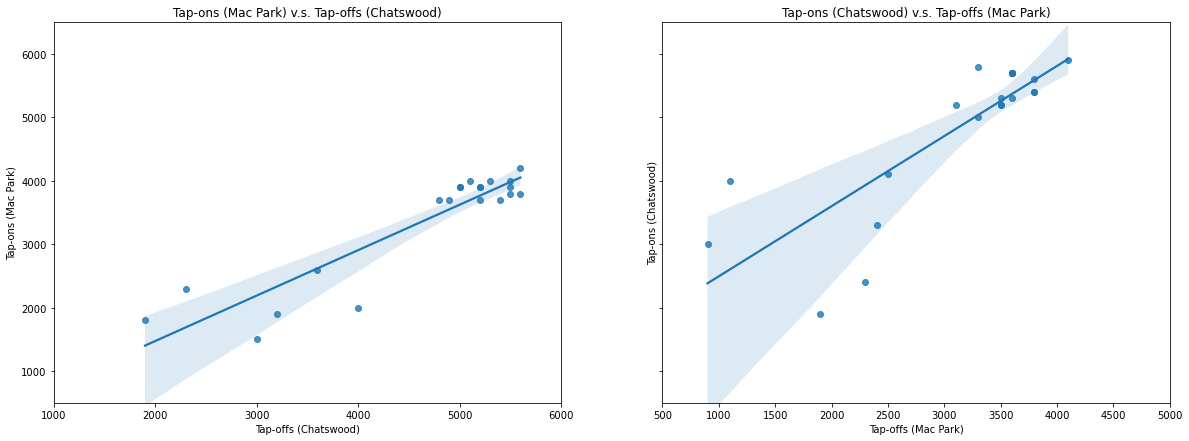

In [12]:
# create subplots for the regression plotting

# independent value: Tap-offs of Chatswood; dependent value: Tap-ons of Macquarie Park
fig, axes = plt.subplots(figsize = (20,7), ncols=2, sharey= True)
plot_a = sns.regplot(x= "Tap-offs (Chatswood)", y= "Tap-ons (Mac Park)", data= mac_chats_taps, ax=axes[0])
plot_a.set_title("Tap-ons (Mac Park) v.s. Tap-offs (Chatswood)")
plot_a.set(xlim=(1000, 6000))
plot_a.set(ylim=(500, 6500))

# independent value: Tap-offs of Macquarie Park; dependent value: Tap-ons of Chatswood
plot_b = sns.regplot(x= "Tap-offs (Mac Park)", y= "Tap-ons (Chatswood)", data= chats_mac_taps, ax=axes[1])
plot_b.set_title("Tap-ons (Chatswood) v.s. Tap-offs (Mac Park)")
plot_b.set(xlim=(500, 5000))
plot_b.set(ylim=(500, 6500))

* Interpretation: From the two plots above, we observe that the distance from each point to the regressive line of the first plot is closer compared to the second plot. Thus, **we will build the linear regression model for the first plot (i.e. Predict the tap-on events in Macquarie Park based on the tap-off events in Chatswood)**.

**Second Group (Strathfield v.s. Parramatta):**

[(500.0, 12000.0)]

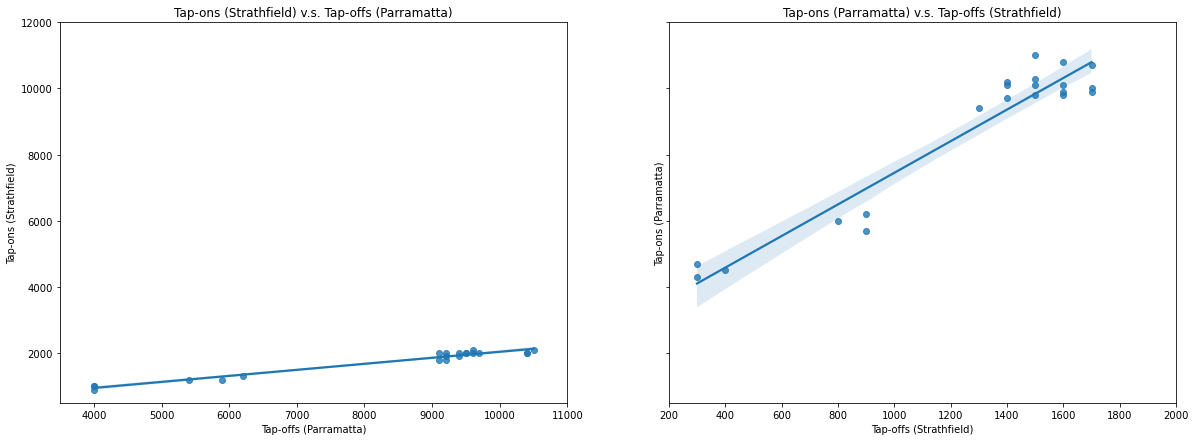

In [13]:
# create subplots for the regression plotting

# independent value: Tap-offs of Parramatta; dependent value: Tap-ons of Strathfield.
fig, axes = plt.subplots(figsize = (20,7), ncols=2, sharey=True)
plot_c = sns.regplot(x= "Tap-offs (Parramatta)", y= "Tap-ons (Strathfield)", data= strath_parra_taps, ax=axes[0])
plot_c.set_title("Tap-ons (Strathfield) v.s. Tap-offs (Parramatta)")
plot_c.set(xlim=(3500, 11000))
plot_c.set(ylim=(500, 12000))

# independent value: Tap-offs of Strathfield; dependent value: Tap-ons of Parramatta.
plot_d = sns.regplot(x= "Tap-offs (Strathfield)", y= "Tap-ons (Parramatta)", data= parra_strath_taps, ax=axes[1])
plot_d.set_title("Tap-ons (Parramatta) v.s. Tap-offs (Strathfield)")
plot_d.set(xlim=(200, 2000))
plot_d.set(ylim=(500, 12000))

* Interpretation: From the two plots above, we observe that the distance from each point to the regressive line of the first plot is closer compared to the second plot. Thus, **we will build the linear regression model for the first plot (i.e. Predict the tap-on events in Strathfield based on the tap-off events in Parramatta)**.

## Model Building

We build the linear regression model for the two groups we presented previously. Let X (independent variable) be the tap-off events, and y (dependent variable) be the tap-on events.

### Model for First Group(Macquarie Park v.s. Chatswood):

We predict the tap-on events in Macquarie Park based on the Tap-off events in Chatswood.

**Create the linear model**

In [14]:
first_reg = linear_model.LinearRegression()

**Split into train and test datasets, and fit data into the model**

In [15]:
# split the dataframe into train (80%) and test (20%) with random state = 142
first_train, first_test= train_test_split(mac_chats_taps, test_size=0.2, random_state=142)
print("train size:", first_train.shape)
print("test size:", first_test.shape)

train size: (16, 2)
test size: (5, 2)


In [16]:
# fit the data in train into the regression model
first_X_train = first_train[['Tap-offs (Chatswood)']]
first_y_train = first_train['Tap-ons (Mac Park)']

first_reg.fit(first_X_train, first_y_train)

LinearRegression()

In [17]:
# assign the variables of testing dataset
first_X_test = first_test[['Tap-offs (Chatswood)']]
first_y_test = first_test['Tap-ons (Mac Park)']

**Predict tap-on events based on tap-off events**

In [18]:
# do prediction on the train set
first_train_preds = first_reg.predict(first_X_train)
print("The predicted tap-on events on train set are:", first_train_preds)

# do prediction on the test set
first_test_preds = first_reg.predict(first_X_test)
print("The predicted tap-on events on test set are:", first_test_preds)

The predicted tap-on events on train set are: [3755.58732132 3755.58732132 3978.99316346 3978.99316346 3606.65009323
 3755.58732132 3681.11870727 3606.65009323 4053.4617775  2564.08949658
 3904.52454941 4053.4617775  3830.05593536 2117.27781231 2861.96395277
 1595.99751398]
The predicted tap-on events on test set are: [3978.99316346 3457.71286513 3532.18147918 2266.2150404  1298.1230578 ]


**Evaluation**

We apply mean square error (MSE) and $R^2$ to check if the model fits well (i.e. whether the predicted tap-on events is slightly diffferent from the actual tap-on events in Macquarie Park).

In [19]:
print("\nThe test set's MSE is:",mean_squared_error(first_y_test, first_test_preds))
print("The test set's root MSE is:", np.sqrt(mean_squared_error(first_y_test, first_test_preds)))
print("The test set's R squared score is:",r2_score(first_y_test, first_test_preds))


The test set's MSE is: 94660.26395187716
The test set's root MSE is: 307.66908189136774
The test set's R squared score is: 0.8977309162144802


* **_Interpretation:_** The $R^2$ of the testing dataset is roughly 0.898, which the test dataset fits the model quite well. However, the MSE value corresponds to a prediction error of roughly 308 tap-ons at all the transport stops of Macquarie Park, which is approximately 9% of the actual mean value of the tap-off events. Therefore this model might be considered as a quite good model.

### Model for Second Group (Strathfield v.s. Parramatta):

We repeat the same steps as the first group to build the linear model. We predict the tap-on events in Strathfield based on the tap-off events in Parramatta.

**Create the linear model**

In [20]:
second_reg = linear_model.LinearRegression()

**Split into train and test datasets, and fit data into the model**

In [21]:
# split the dataframe into train (80%) and test (20%) with random state = 142
second_train, second_test= train_test_split(strath_parra_taps, test_size=0.2, random_state=142)
print("train size:", second_train.shape)
print("test size:", second_test.shape)

train size: (16, 2)
test size: (5, 2)


In [22]:
# fit the data in train into the regression model
second_X_train = second_train[['Tap-offs (Parramatta)']]
second_y_train = second_train['Tap-ons (Strathfield)']

second_reg.fit(second_X_train, second_y_train)

LinearRegression()

In [23]:
# assign the variables of testing dataset
second_X_test = second_test[['Tap-offs (Parramatta)']]
second_y_test = second_test['Tap-ons (Strathfield)']

**Predict tap-on events based on tap-off events**

In [24]:
# do prediction on the train set
second_train_preds = second_reg.predict(second_X_train)
print("The predicted tap-on events on train set are:", second_train_preds)

# do prediction on the test set
second_test_preds = second_reg.predict(second_X_test)
print("The predicted tap-on events on test set are:", second_test_preds)

The predicted tap-on events on train set are: [1948.83611266 1968.26638659 2007.12693445 1968.26638659 1987.69666052
 1948.83611266 1987.69666052 1909.9755648  1890.54529086 1327.06734685
 1909.9755648  2162.56912591 2143.13885197  899.60132036 1268.77652506
 1171.6251554 ]
The predicted tap-on events on test set are: [2143.13885197 1890.54529086 1909.9755648   899.60132036  899.60132036]


**Evaluation**

We apply mean square error (MSE) and $R^2$ to check if the model fits well (i.e. whether the predicted tap-on events is slightly diffferent from the actual tap-on events in Strathfield).

In [25]:
print("\nThe test set's MSE is:",mean_squared_error(second_y_test, second_test_preds))
print("The test set's root MSE is:", np.sqrt(mean_squared_error(second_y_test, second_test_preds)))
print("The test set's R squared score is:",r2_score(second_y_test, second_test_preds))


The test set's MSE is: 9789.29645655884
The test set's root MSE is: 98.94087353848681
The test set's R squared score is: 0.9506587880213768


* **_Interpretation:_** The $R^2$ of the testing dataset is significantly high, which is roughly 0.951. this means the test dataset fits the model well. The MSE value corresponds to a prediction error of roughly 99 tap-ons at all the transport stops of Strathfield, which is approximately 6% of the actual mean value of the tap-off events. Therefore this model might be considered as a good model.

## Conclusion

There could be many factors that can affect on the datasets. For example, there is train service in Chatswood while there is only bus and metro services in Macquarie Park. Another example is that there is no ferry service in Strathfield while the tap-offs in Parramatta includes passengers of Parramatta Wharf. 

We have built two of the linear regression models to analyse the relationship between the tap-ons at all the transport stops in one suburb and the tap-offs at all the transport stops in another suburbs. We build one model for the relationship between the tap-ons in Macquarie Park and the tap-offs in Chatswood, and another model for the relationship between the tap-ons in Strathfield and the tap-offs in Parramatta.

From the two models, we can clearly notice that the model for Strathfield and Parramatta is better than the model for Macquarie Park and Chatswood. In fact, the $R^2$ of the former model is up to 0.951 compared to 0.898 of the later model. Moreover, the percentage of root mean squared error comapred to the actual mean value of the "Strathfield v.s. Parramatta" model is considerably lower than the "Macquarie Park v.s. Chatswood" model, which is 6% and 9% to the actual mean values respectively. 

Thus, we can conclude that the prediction for the tap-on rate in Parramatta is more precise compare to the prediction for Macquarie Park. Based on this model, we then can predict the traveling trend from the two nearby suburbs and give recommendation for passengers to plan ahead, especially traveling under the Covid-19 circumstance around the key commercial cities (e.g. Parramatta).